# What is the Project?
- This project is an attempt to create a machine learning model that can accurately classify whether a tumor is malignant or benign using PCA and then applying those results to other models. 

### Dataset Citation - MLA

- Learning, UCI Machine. “Breast Cancer Wisconsin (Diagnostic) Data Set.” Kaggle, 25 Sept. 2016, www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data. 

# About the Dataset

This dataset is from the UCI machine learning repository and uploaded to kaggle where I downloaded it. The dataset is already clean; however, the data does include two unneccessary columns and it may need to be transformed or rebalanced to be used for PCA analysis.
- The dataset has 33 features with diagnosis being the only categorical feature.
- There are 569 records in this dataset.
- At this point I do not have any background information or prior knowledge on the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv("BC_data.csv")

data.shape

(569, 33)

In [3]:
print(data.info())
print(data.head())
print(data.nunique())
print(data.isnull())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## Data Usefulness
- In the current state, this data is not very useful. It has 32 features. Before starting any analysis ID will be removed and also the blank column at the end.


In [4]:
data = data.drop(['id', 'Unnamed: 32'], axis = 1)

We will use PCA to try to reduce the dimensions significantly. This will hopefully result in a large reduction of dimensions and possibly produce a good model as well.

In [5]:
data.shape

(569, 31)

In [6]:
X = data.drop(['diagnosis'], axis = 1)
y = data[['diagnosis']]

Looking at the plot below we can see that the data is unbalanced to a degree. We will need to solve this before making any analysis. 

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

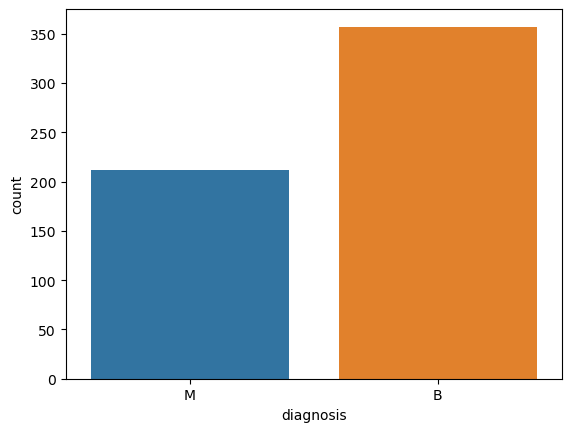

In [7]:
sns.countplot(data = y, x = 'diagnosis')

The below code is just scaling for using PCA. 

In [8]:
from scipy.stats import zscore
X1 = X.apply(zscore)

In [9]:
cov_mat = np.cov(X1, rowvar = False)

If we want to account for 95% of the variance we use the below code.

In [10]:
pca = PCA(n_components=0.95)

In [11]:
pca.fit(X1)

PCA(n_components=0.95)

In [12]:
print(pca.explained_variance_ratio_)

[0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734 0.01588724 0.01389649 0.01168978]


In [13]:
print(sum(pca.explained_variance_ratio_))

0.9515688143366667


In [14]:
pcafin = pca.transform(X1)

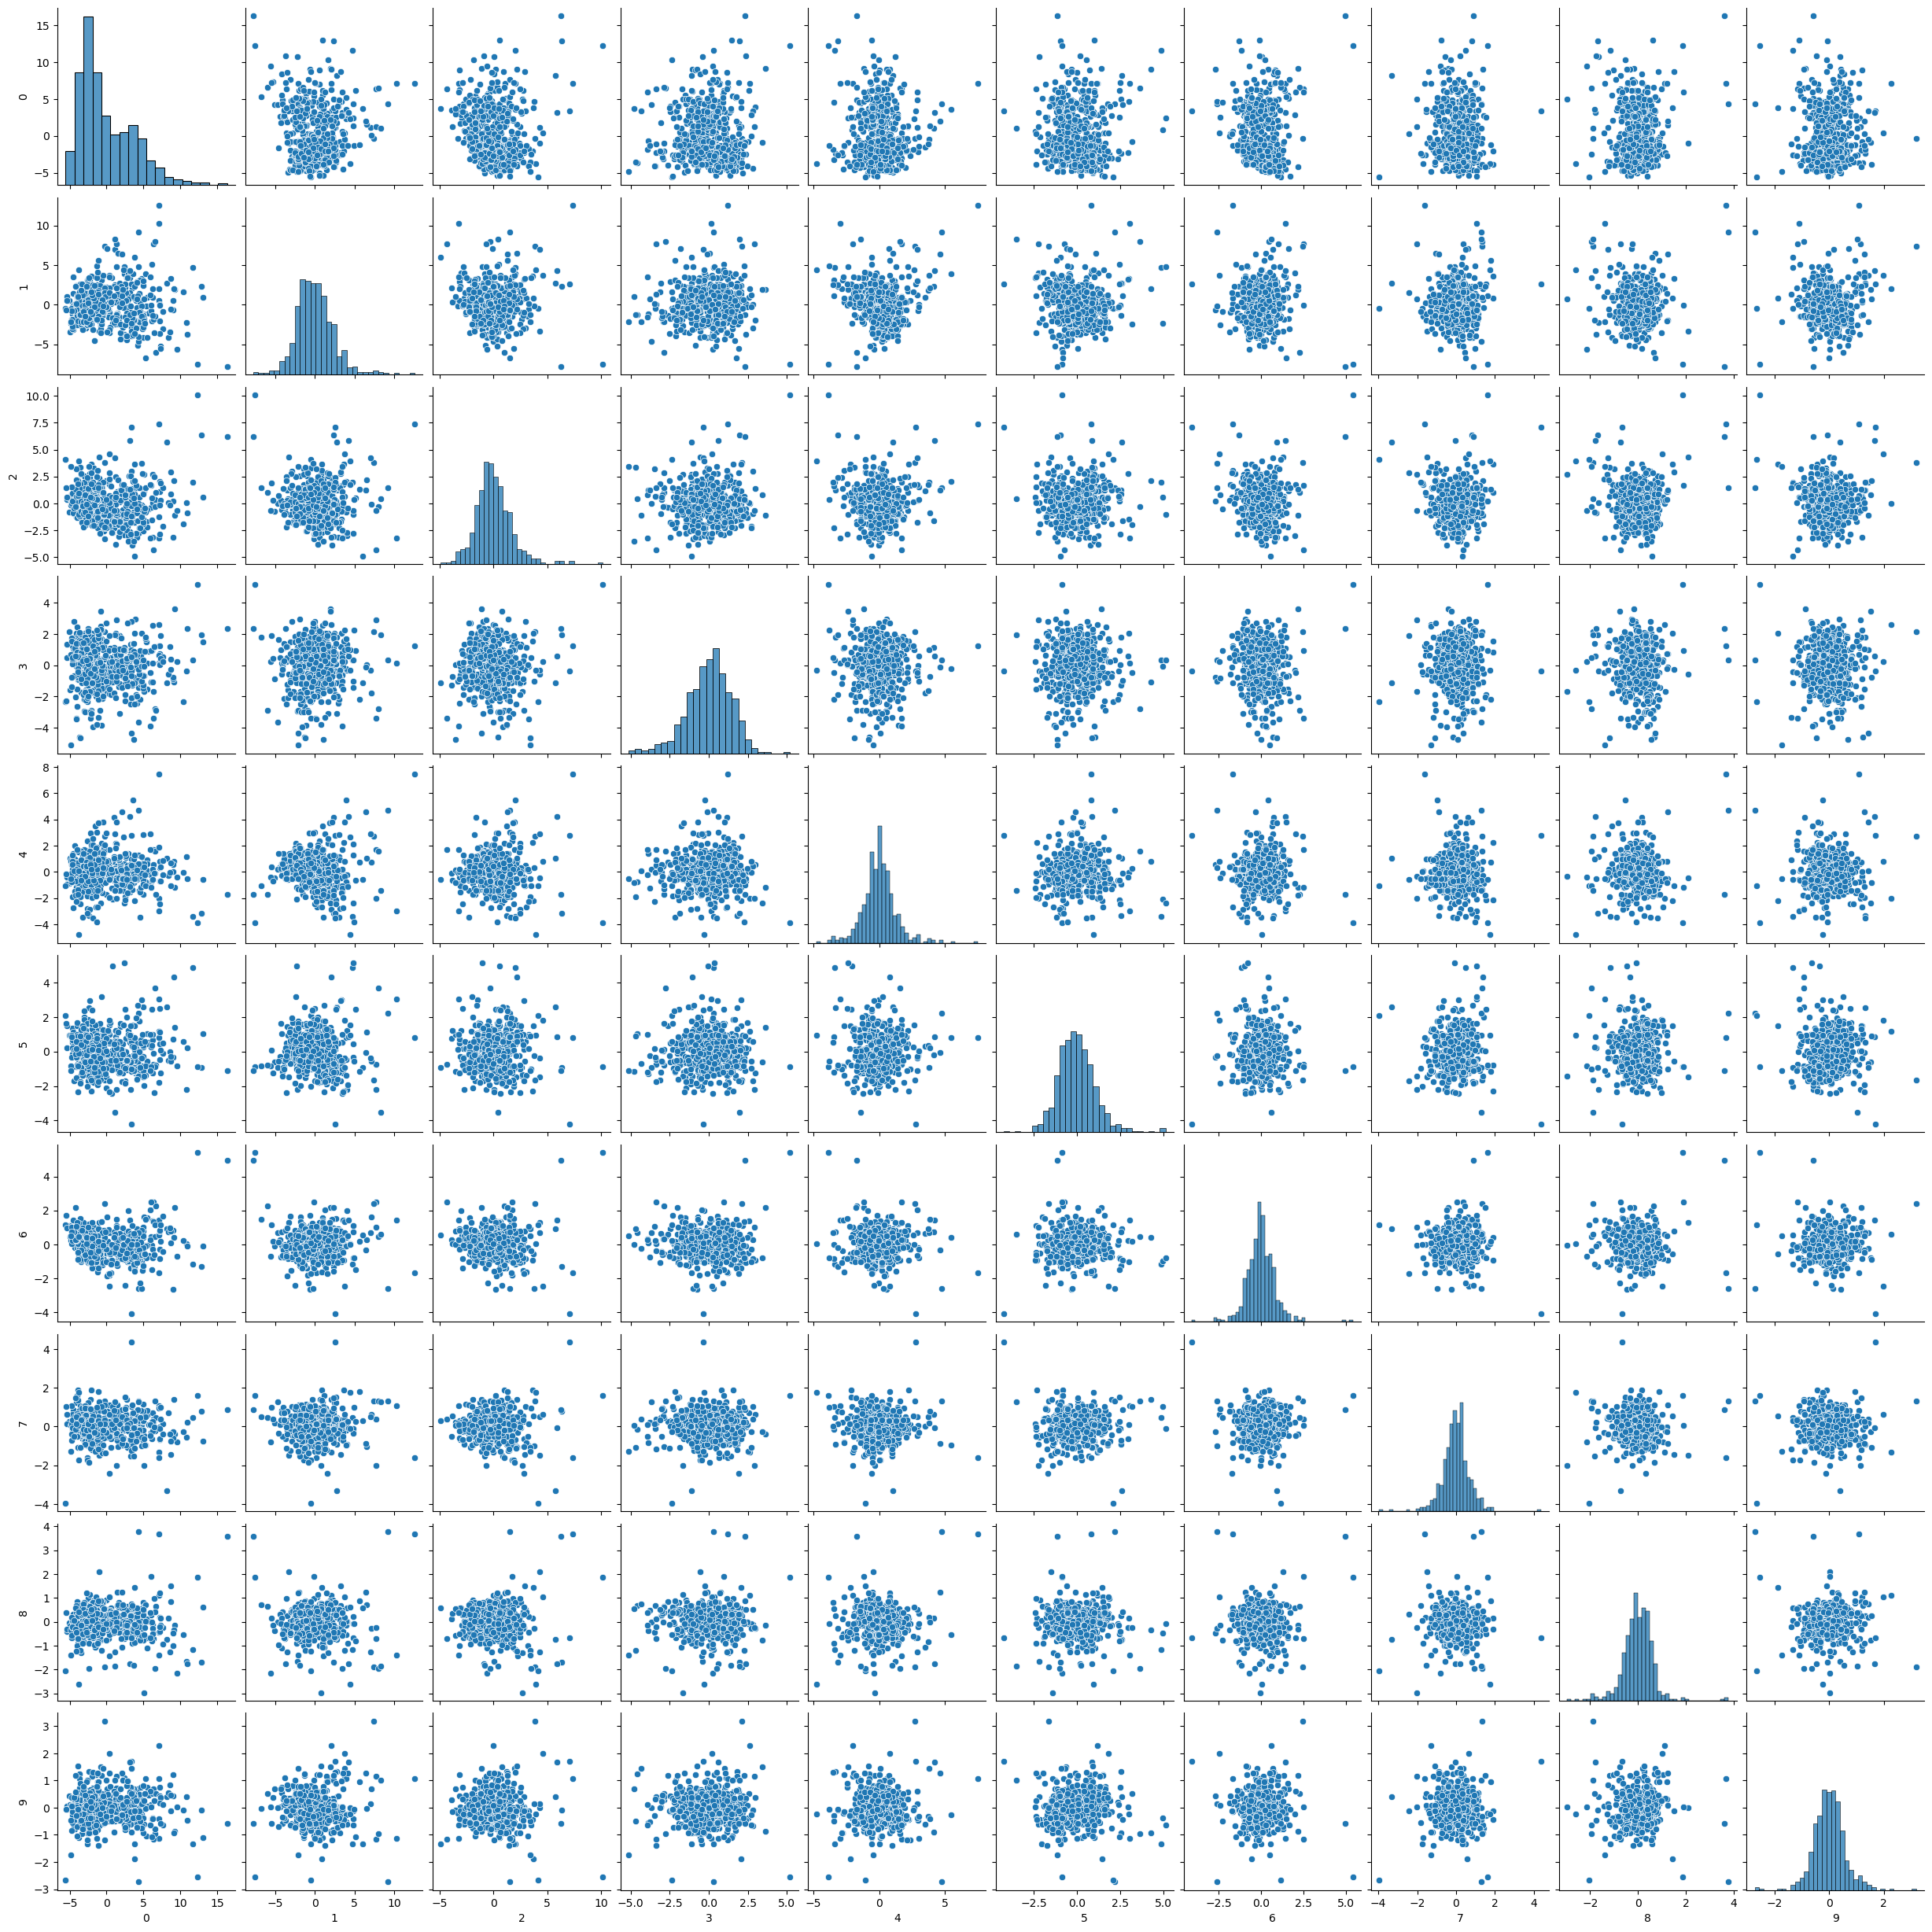

In [15]:
sns.pairplot(pd.DataFrame(pcafin))

This distribution looks fairly unbalanced, so in order to use PCA most effectively we will have to balance it to some degree.

In [16]:
from imblearn.over_sampling import SMOTE

s = SMOTE()
X_bal, y_bal = s.fit_resample(pcafin, y)

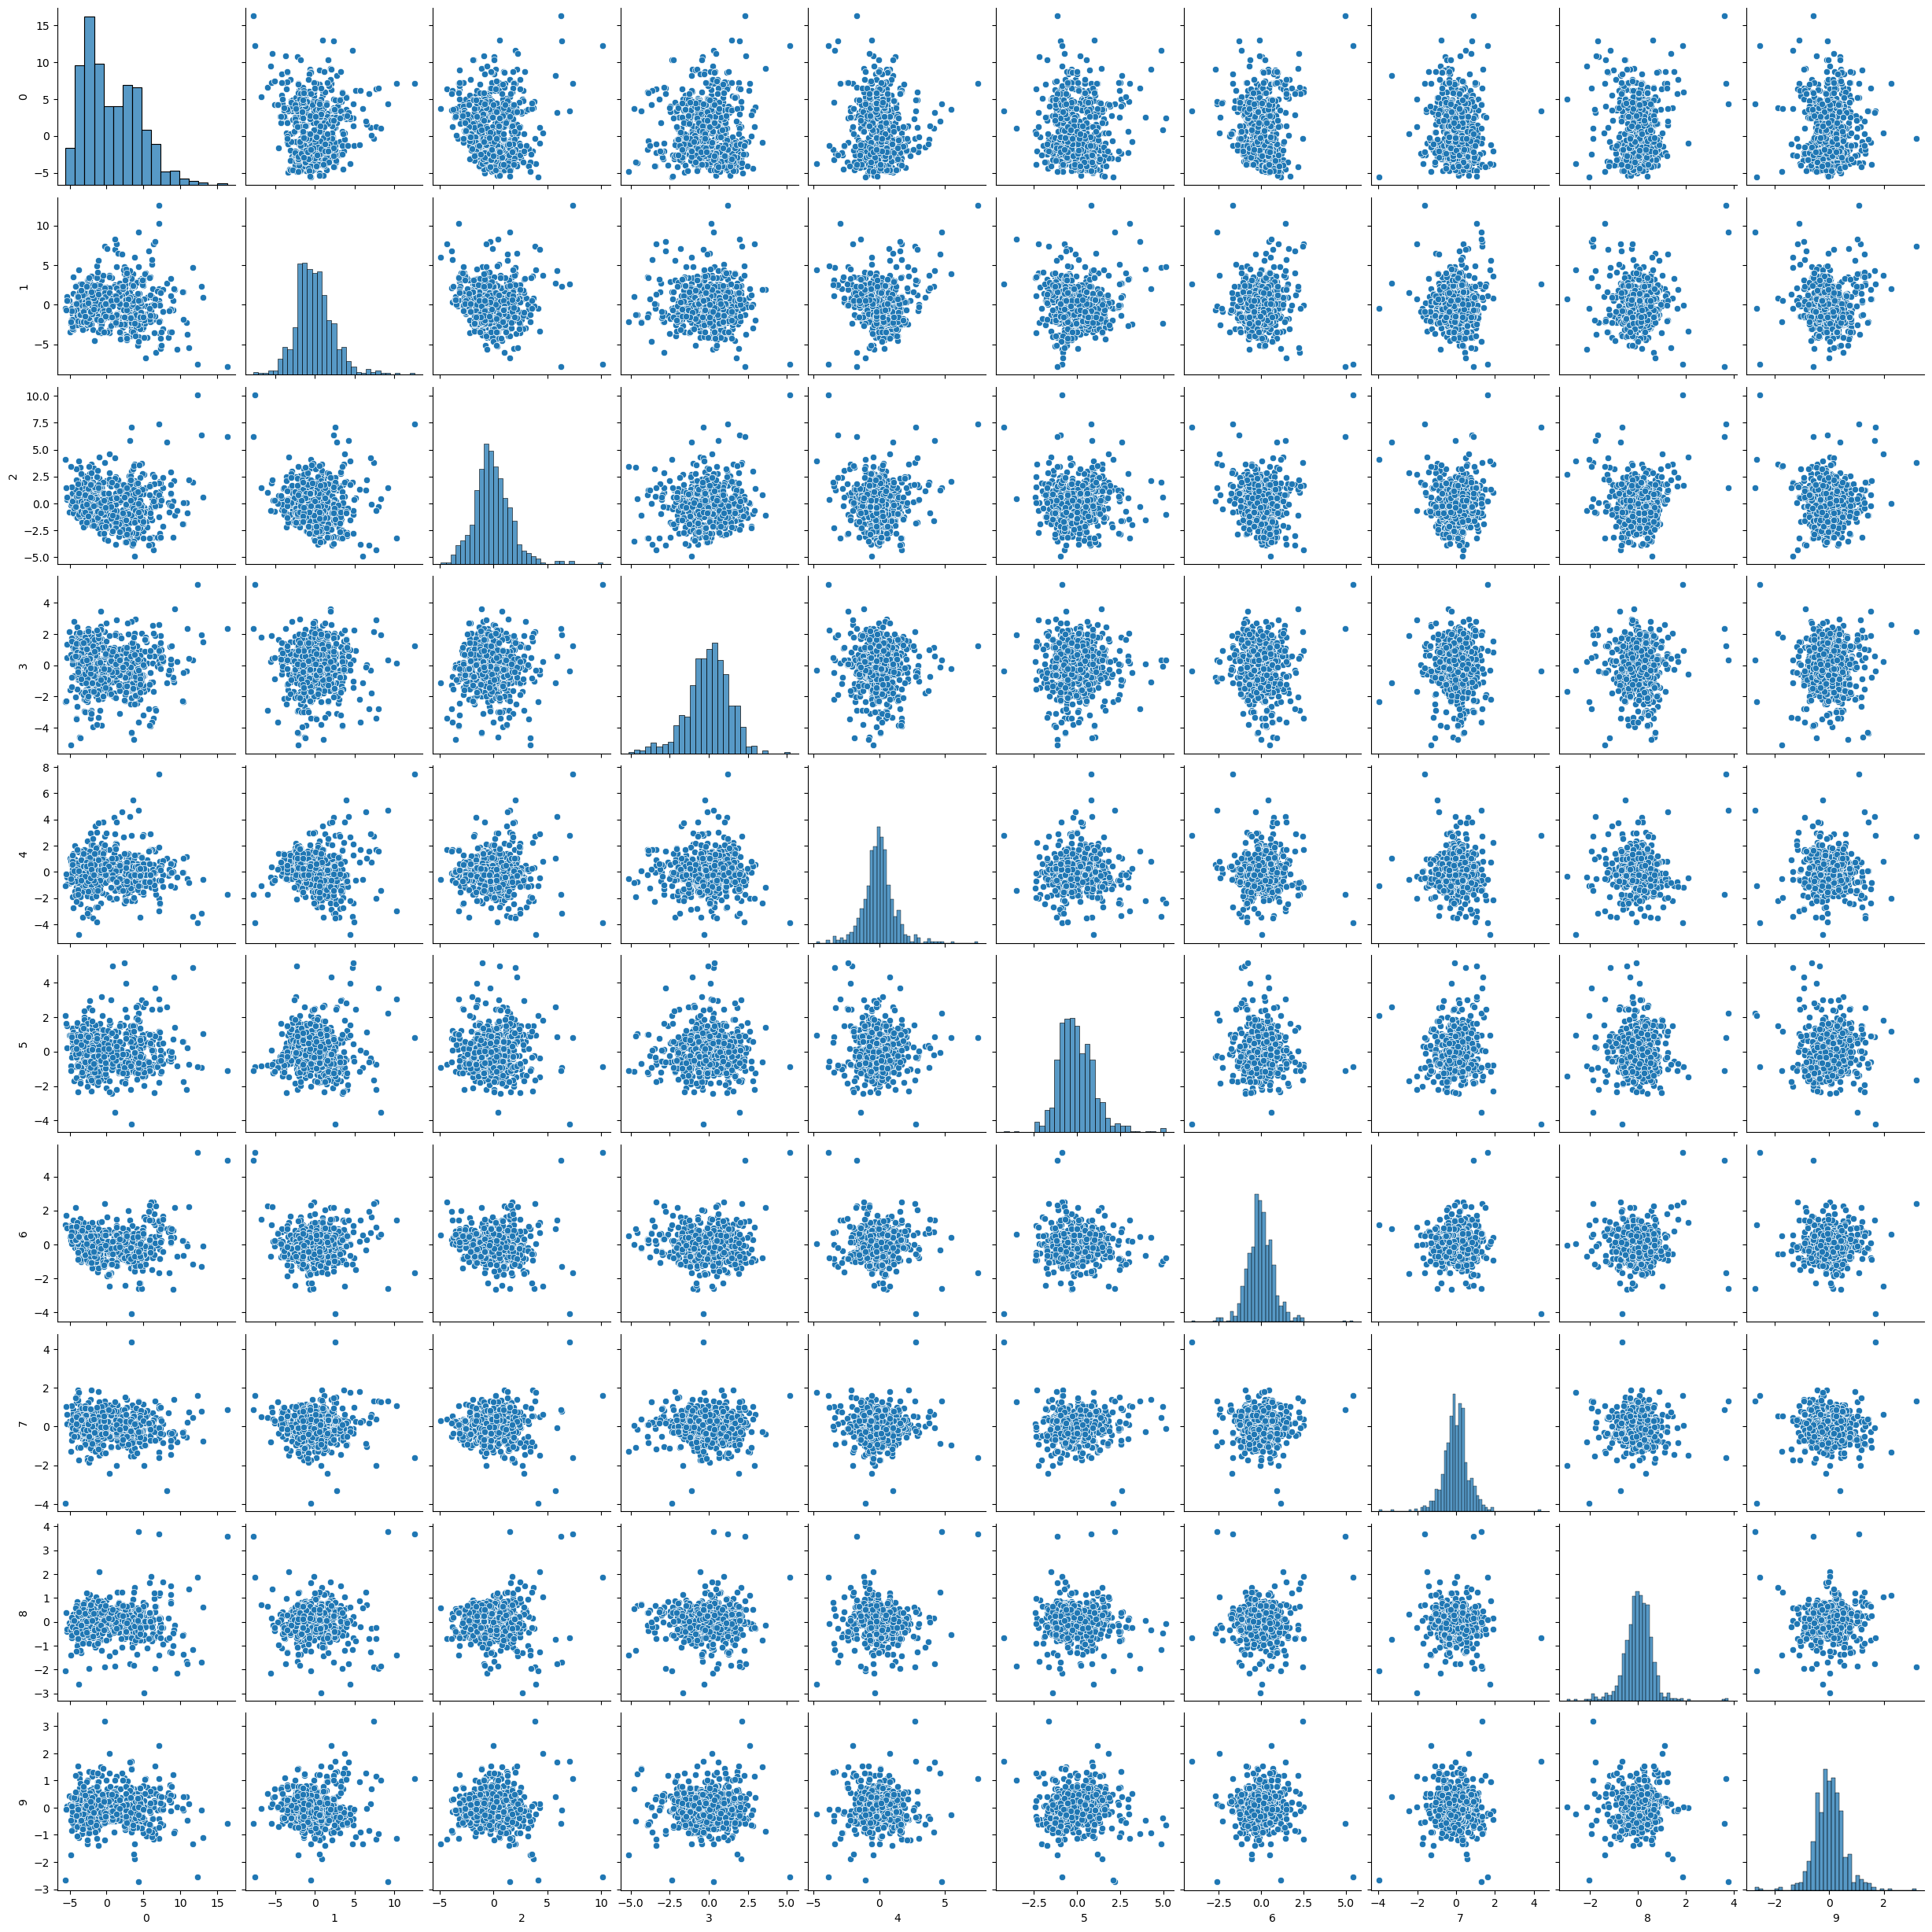

In [17]:
sns.pairplot(pd.DataFrame(X_bal))

We balance the data using SMOTE which is an oversampling technique that is designed to avoid potential overfitting caused by random oversampling. This should be very helpful in using PCA.

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

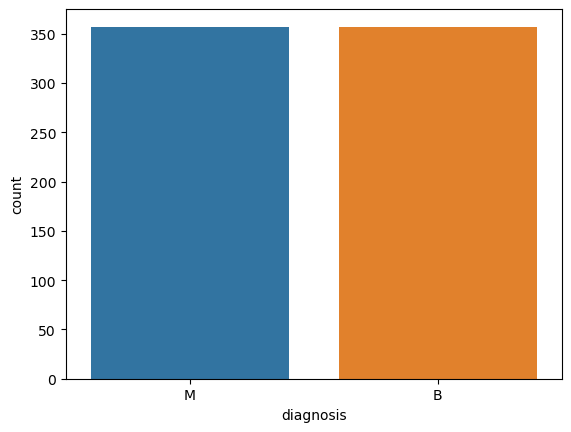

In [18]:
sns.countplot(data = y_bal, x = 'diagnosis')

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size = 0.25, random_state = 20)

y_train

,diagnosis
416,B
346,B
517,M
553,B
21,B
...,...
218,M
223,M
271,B
474,B


# Data Modeling
- As a side note, PCA is the unsupervised learning method used here. The rest of these models will be to compare how useful the PCA is for this dataset
- At this point we've balanced the dataset and used PCA to get new features, we should see how accurate models are. To do this we'll use a random forest and logistic regression model. We'll then go back and see what the results would have been without using PCA. 

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

rf = RandomForestRegressor(max_depth = 10, random_state = 5)

# This is to convert y_train to numeric values. Categorical values will not work.
y_trainrf = y_train['diagnosis'].apply(lambda val: 1 if val == 'M' else 0)
y_testrf = y_test['diagnosis'].apply(lambda val: 1 if val == 'M' else 0)

In [21]:
rf_fit = rf.fit(X_train, y_trainrf)

In [22]:
print(rf_fit.score(X_test, y_testrf))

0.884937776303943


In [23]:
pca_mod = LogisticRegression()
pca_mod.fit(X_train, y_train)
y_pred = pca_mod.predict(X_test)
train_score = pca_mod.score(X_train, y_train)
test_score = pca_mod.score(X_test, y_test)

C:\Users\joeyc\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
print(train_score)

0.9757009345794393


In [25]:
print(test_score)

0.9832402234636871


This test score is very good at 0.98 after using PCA and logistic regression. 

### Models w/o PCA
- Since the models above use PCA we need base models without PCA to compare to. We will create those below.

In [26]:
X_bal1, y_bal1 = s.fit_resample(X, y)

In [27]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_bal1, y_bal1, test_size = 0.25, random_state = 20)

In [28]:
y_trainrf1 = y_train1['diagnosis'].apply(lambda val: 1 if val == 'M' else 0)
y_testrf1 = y_test1['diagnosis'].apply(lambda val: 1 if val == 'M' else 0)

In [29]:
rf_fit1 = rf.fit(X_train1, y_trainrf1)

In [30]:
print(rf_fit1.score(X_test1, y_testrf1))

0.9283977647352647


So we can see that a random forest model really does not benefit from the use of PCA. This could be somewhat expected since random forest models are not necessarily suited to this type of problem. Realistically it is a binary problem, M or B, so the real interesting model would be the logistic regression one we'll do next.

In [31]:
mod1 = LogisticRegression(max_iter=10000)
mod1.fit(X_train1, y_train1)
y_pred1 = mod1.predict(X_test1)
train_score1 = mod1.score(X_train1, y_train1)
test_score1 = mod1.score(X_test1, y_test1)

C:\Users\joeyc\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
print(train_score1)

0.9570093457943926


In [33]:
print(test_score1)

0.9608938547486033


# Final Results
- Final Test Scores for each model type
    - Logistic Regression
        - PCA = 0.98
        - Non-PCA = 0.96
    - Random Forest
        - PCA = 0.88
        - Non-PCA = 0.93
                - These results do vary slightly if the code is re-ran, but the general premise remains the same.

# Conclusion
- PCA provided a significant boost to test score when it came to logistic regression and no boost to the random forest model. 
- Overall this project showed significant value to using PCA when it comes to feature reduction. The model started with 31 real columns, not including ID or the blank column, and PCA brought it down to 10 features. This allowed us to make a significantly more accurate logistic regression model.
- I think the biggest improvement to this project would be more data. The dataset is small with only 569 entries, so it would be interesting to see if the model performed as well on a larger dataset. 